## 서울시 서초구, 양천구 주차시설 확보를 위한 데이터 분석 프로젝트
### 프로젝트 개요
본 프로젝트는 서울시 서초구와 양천구의 공영주차장 정보 및 불법 주정차 단속 현황 데이터를 분석하여, 각 지역의 주차 문제를 파악하고 주차 공간 공급과 불법 주정차 발생 간의 연관성을 시각적으로 탐색합니다. 최종적으로 데이터 분석 결과를 바탕으로 주차 문제 해결을 위한 아이디어를 제안하는 것을 목표로 합니다.

# **<1일차 개별과제>**


## 1. 환경 설정 및 데이터 불러오기
### 1.1. 라이브러리 임포트 및 한글 폰트 설정
분석에 필요한 라이브러리를 불러오고, 시각화 시 한글이 깨지지 않도록 맑은고딕 폰트를 설정합니다

In [1]:
# 데이터 분석 및 시각화를 위한 라이브러리들을 임포트합니다.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
from datetime import datetime
import os
import glob
import matplotlib.font_manager as fm
import subprocess

# 폰트 설정
plt.rc('font', family='Malgun Gothic')

# 경고 제거
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus']=False #마이너스 부호 깨짐 방지

## 1.2. 데이터 불러오기 및 전처리
서초구와 양천구의 공영주차장 및 주정차 단속 데이터를 불러온 후, 분석에 용이하도록 데이터 형식을 변환하고 정제하는 전처리 과정을 진행합니다.

### 1) 데이터 불러오기
서초구 및 양천구 공영주차장 및 주정차 단속 데이터를 로드합니다. 

**참고사항**: 한글 깨짐현상의 원인은 한글 표현하는 인코딩이 다르기 때문입니다. <br/>
파일을 읽어 올때 encoding을 설정해서 로드 합니다. (encoding='cp949'은 한글 파일을 읽기 위함)

**로드할 파일**
  - 서울시 서초구 공영주차장 안내 정보
  - 서울특별시 서초구_주정차단속 시간별 현황
  - 서울시 양천구 공영주차장 안내 정보
  - 서울특별시 양천구_주정차위반단속현황 (20231220, 20221231)

In [3]:
seocho_parking_lot = pd.read_csv('서울시 서초구 공영주차장 안내 정보.csv', encoding='cp949')
seocho_crackdown = pd.read_csv('서울특별시 서초구_주정차단속 시간별 현황_20241231.csv', encoding='cp949')
yangcheon_parking_lot = pd.read_csv('서울시 양천구 공영주차장 안내 정보.csv', encoding='cp949')
yangcheon_crackdown_2023 = pd.read_csv('서울특별시 양천구_주정차위반단속현황_20231220.csv', encoding='cp949')
yangcheon_crackdown_2022 = pd.read_csv('서울특별시_양천구_주정차위반단속현황_20221231.csv', encoding='cp949')

### 2) 데이터 전처리 및 탐색 (1)

**서초구 데이터 전처리**
  - 단속일시 컬럼은 형식을 변환하고 유효한 값이 없는 경우 제거하고, 분석에 필요한 정보를 정리해 봅니다.
  - 단속동 컬럼 및 주소 컬럼에서 동이름을 추출하여 정리 합니다.

In [4]:
# seocho_crackdown.info() #단속 일시 Dtype: object -> datetime으로 변경 필요, null값 없음
seocho_crackdown['단속일시'] = pd.to_datetime(seocho_crackdown['단속일시'], errors='coerce')
seocho_crackdown.dropna(subset=['단속일시'], inplace=True)
seocho_crackdown['단속시간'] = seocho_crackdown['단속일시'].dt.hour

In [5]:
# '단속동' 컬럼에서 'OO동' 형태의 문자열만 추출하여 정리
seocho_crackdown['단속동'] = seocho_crackdown['단속동'].str.extract(r'([가-힣]+동)')
# '주소' 컬럼에서 동 이름만 추출하여 '주소_동' 컬럼 생성
seocho_parking_lot['주소_동'] = seocho_parking_lot['주소'].str.split().str[1]

### 2) 데이터 전처리 및 탐색 (2)

**양천구 데이터 전처리**

  - 2개의 단속 정보 파일을 로드해서 동일한 컬럼 구성을 가지도록 합쳐 봅니다.
  - 유효하지 않는 단속 정보(단속일시, 단속동, ...)를 정리 합니다.

In [6]:
yangcheon_crackdown = pd.concat([yangcheon_crackdown_2022, yangcheon_crackdown_2023], ignore_index=True)
yangcheon_crackdown = yangcheon_crackdown.dropna(axis=1) #unnamed 제거
yangcheon_crackdown

,연번,단속일시,단속원금,단속동,단속장소,위반내용
0,1,2022-01-01 00:19,40000,목동,4동목동중앙본로5길 65-8,교통소통장애
1,2,2022-01-01 05:36,40000,신정동,4동중앙로300,횡단보도
2,3,2022-01-01 06:12,40000,목동,7동목동아파트123동,횡단보도
3,4,2022-01-01 09:45,40000,신월동,서울특별시 양천구 남부순환로 340,보도
4,5,2022-01-01 09:47,120000,신정동,7동목동@1214동앞,소화전
...,...,...,...,...,...,...
135844,64419,2023-12-26 21:42,50000,신정동,서울 양천구 신정동 311-14,주차금지(황색점선)구역
135845,64420,2023-12-26 21:45,40000,신정동,서울 양천구 신정동 1146,횡단보도
135846,64421,2023-12-26 21:47,40000,신정동,서울 양천구 신정동 1144,횡단보도
135847,64422,2023-12-26 23:16,40000,신월동,서울 양천구 신월동 1000-1,횡단보도


In [7]:
# '단속일시' 컬럼을 datetime 형식으로 변
yangcheon_crackdown['단속일시'] = pd.to_datetime(yangcheon_crackdown['단속일시'], errors='coerce') #단속일시 dtype을 날짜 형식으로 변환
# 유효하지 않은 '단속일시' 행 제거
yangcheon_crackdown.dropna(subset=['단속일시'], inplace=True)
# 시간(hour) 정보를 '단속시간' 컬럼으로 추출
yangcheon_crackdown['단속시간'] = yangcheon_crackdown['단속일시'].dt.hour

In [8]:
# '단속동'의 양쪽 공백 제거
yangcheon_crackdown['단속동'] = yangcheon_crackdown['단속동'].str.strip()
# '목 동'으로 잘못 표기된 데이터를 '목독'으로 통일
yangcheon_crackdown.loc[yangcheon_crackdown['단속동'] == '목 동', '단속동'] = '목동'
# 주차장 데이터에서도 '주소'를 기반으로 '주소_동' 컬럼 생성
yangcheon_parking_lot['주소_동'] = yangcheon_parking_lot['주소'].str.split().str[1]

## 2. 데이터 분석 및 시각화
### 2.1. 지역별 불법 주정차 단속 현황 비교
각 구별로 어느 동에서 불법 주정차 단속이 가장 많이 발생하는지 상위 10개 동을 막대그래프로 시각화하여 비교합니다.


### **단속 현황 비교**
구별로 단속 현황을 시각화 해 보고 ,어떤 동에서 불법 주정차 단속이 가장 많이 발생하는지 확인해 봅니다.

**서초구 단속 현황**
  - '단속동'별로 단속 건수를 세고, 가장 많은 상위 10개 동을 추출합니다. 
  - Seaborn의 barplot을 이용해 서초구 단속 상위 10개 동을 시각화합니다.

**양천구 단속 현황**
  - '단속동'별로 단속 건수를 세고, 가장 많은 상위 10개 동을 추출합니다.
  - Seaborn의 barplot을 이용해 서초구 단속 상위 10개 동을 시각화합니다.

**1) 지역별 불법 주정차 단속 현황**

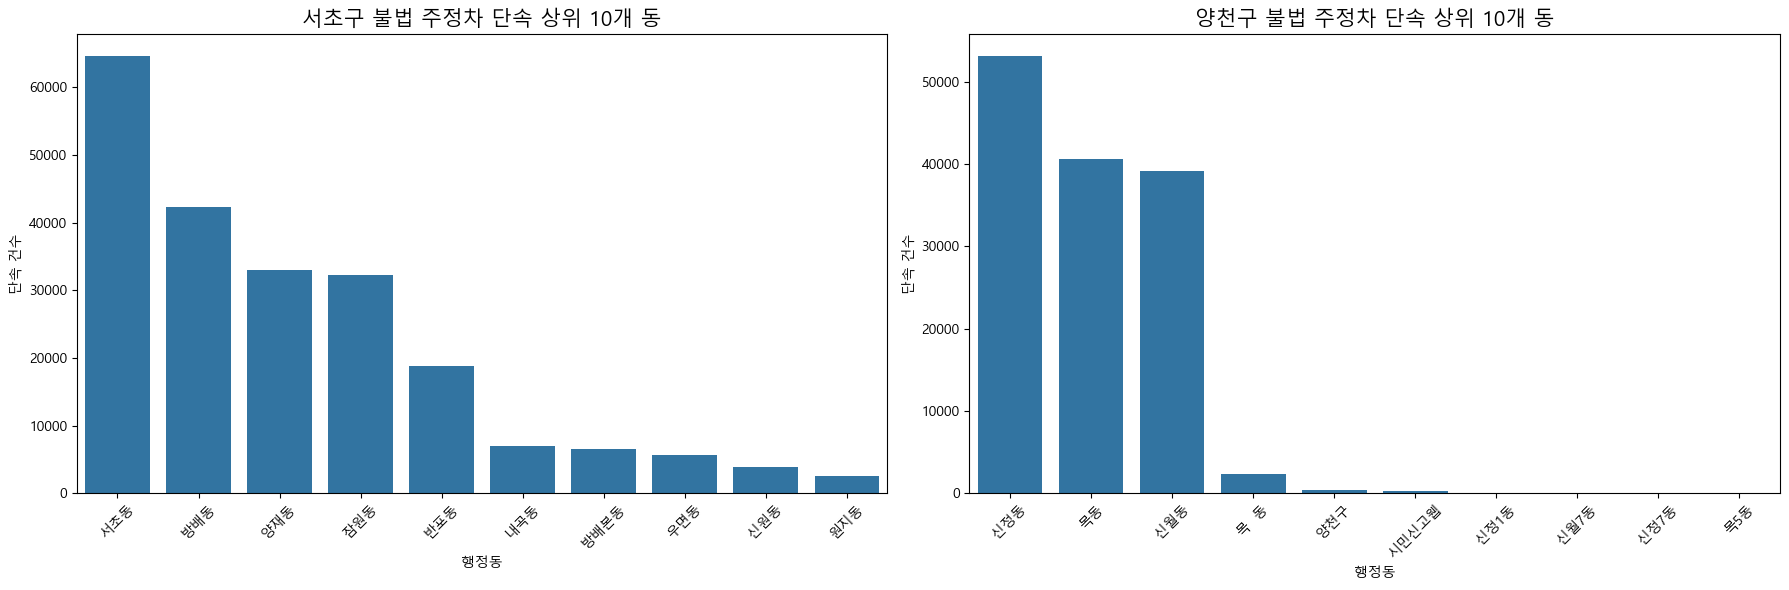

In [9]:
# 1행 2열의 서브플롯(그래프 공간)을 생성합니다. figsize로 전체 그림의 크기를 조절합니다.
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 서초구 단속 현황
# '단속동'별로 단속 건수를 세고, 가장 많은 상위 10개 동을 추출합니다.
seocho_top_dong = seocho_crackdown['단속동'].value_counts().nlargest(10)
# Seaborn의 barplot을 이용해 서초구 단속 상위 10개 동을 시각화합니다. (axes[0]은 첫 번째 그래프 공간)
sns.barplot(x=seocho_top_dong.index, y=seocho_top_dong.values, ax=axes[0])
axes[0].set_title('서초구 불법 주정차 단속 상위 10개 동', fontsize=15) # 그래프 제목 설정
axes[0].set_xlabel('행정동') # x축 라벨 설정
axes[0].set_ylabel('단속 건수') # y축 라벨 설정
axes[0].tick_params(axis='x', rotation=45) # x축 눈금 라벨을 45도 회전시켜 가독성을 높입니다.

# 양천구 단속 현황
# '단속동'별 단속 건수 상위 10개 동을 추출합니다.
yangcheon_top_dong = yangcheon_crackdown['단속동'].value_counts().nlargest(10)
# 양천구 단속 상위 10개 동을 시각화합니다. (axes[1]은 두 번째 그래프 공간)
sns.barplot(x=yangcheon_top_dong.index, y=yangcheon_top_dong.values, ax=axes[1])
axes[1].set_title('양천구 불법 주정차 단속 상위 10개 동', fontsize=15)
axes[1].set_xlabel('행정동')
axes[1].set_ylabel('단속 건수')
axes[1].tick_params(axis='x', rotation=45)

# 그래프들이 겹치지 않도록 레이아웃을 조정하고 화면에 출력합니다.
plt.tight_layout()
plt.show()

**2) 시간대별 단속 현황**

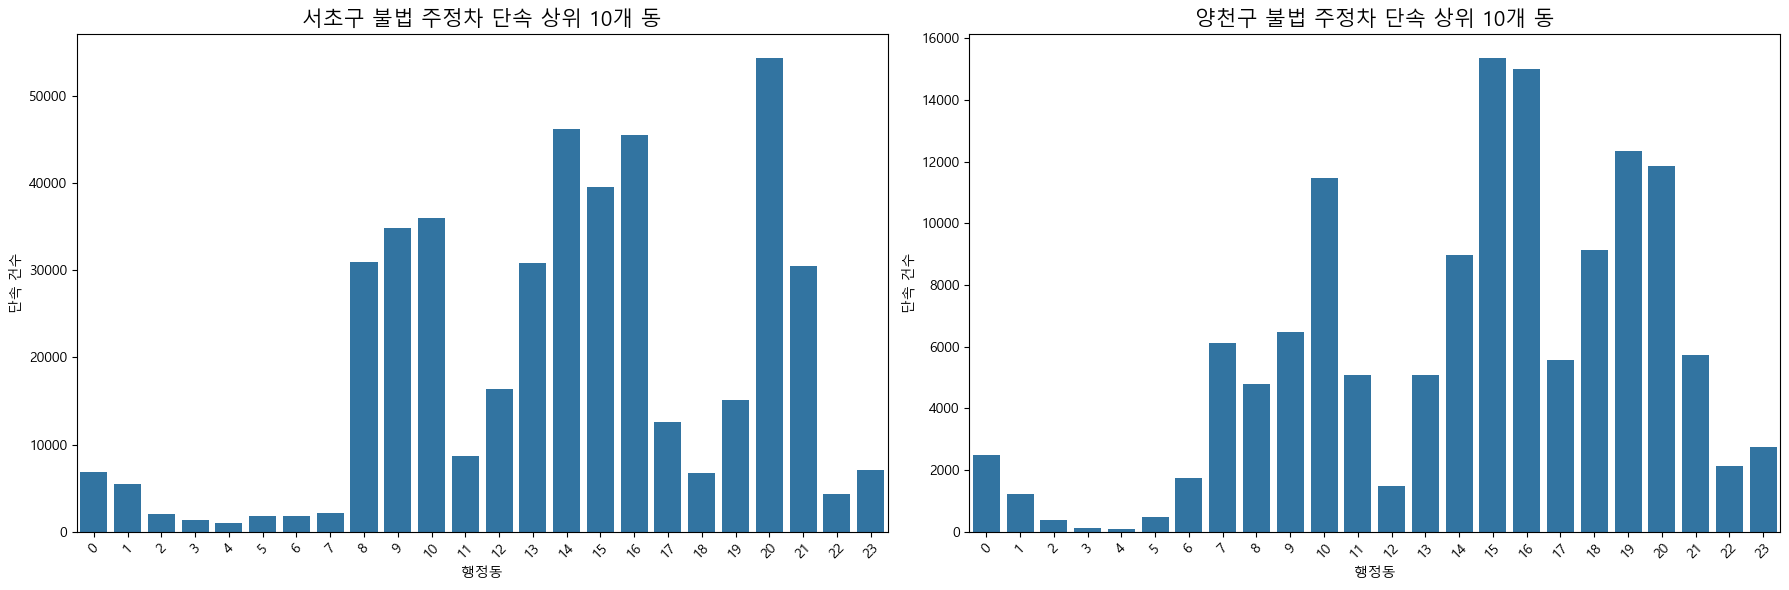

In [10]:
# 1행 2열의 서브플롯(그래프 공간)을 생성합니다. figsize로 전체 그림의 크기를 조절합니다.
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 서초구 단속 현황
# '단속시간'별로 단속 건수를 추출합니다.
seocho_time = seocho_crackdown['단속시간'].value_counts()
# Seaborn의 countplot을 이용해 서초구 단속 시간대를 시각화합니다. (axes[0]은 첫 번째 그래프 공간)
sns.countplot(x='단속시간', data = seocho_crackdown, ax=axes[0])
axes[0].set_title('서초구 불법 주정차 단속 상위 10개 동', fontsize=15) # 그래프 제목 설정
axes[0].set_xlabel('행정동') # x축 라벨 설정
axes[0].set_ylabel('단속 건수') # y축 라벨 설정
axes[0].tick_params(axis='x', rotation=45) # x축 눈금 라벨을 45도 회전시켜 가독성을 높입니다.

# 양천구 단속 현황
# '단속시간'별로 단속 건수를 추출합니다.
yangcheon_time = yangcheon_crackdown['단속시간'].value_counts()
# 양천구 단속 시간대를 시각화합니다. (axes[1]은 두 번째 그래프 공간)
sns.countplot(x='단속시간', data = yangcheon_crackdown, ax=axes[1])
axes[1].set_title('양천구 불법 주정차 단속 상위 10개 동', fontsize=15)
axes[1].set_xlabel('행정동')
axes[1].set_ylabel('단속 건수')
axes[1].tick_params(axis='x', rotation=45)

# 그래프들이 겹치지 않도록 레이아웃을 조정하고 화면에 출력합니다.
plt.tight_layout()
plt.show()

## 2.2. 지역별 공영주차장 공급 현황
각 지역의 행정동별 공영주차장 총 주차면 수를 계산하고 시각화하여 주차 공간 공급 현황을 비교합니다.

### **공급현황 비교**
지역별 공영주차장 공급 현황을 비교 해 봅니다.

**서초구 동별 주차면 수**
  - '주소_동'을 기준으로 그룹화하여 '총 주차면'의 합계를 계산하고, 내림차순으로 정렬합니다.
  - 동별 총 주차면 수를 막대그래프로 시각화합니다.

**양천구 동별 주차면 수**
  - '주소_동'을 기준으로 그룹화하여 '총 주차면'의 합계를 계산하고, 내림차순으로 정렬합니다.
  - 동별 총 주차면 수를 막대그래프로 시각화합니다.

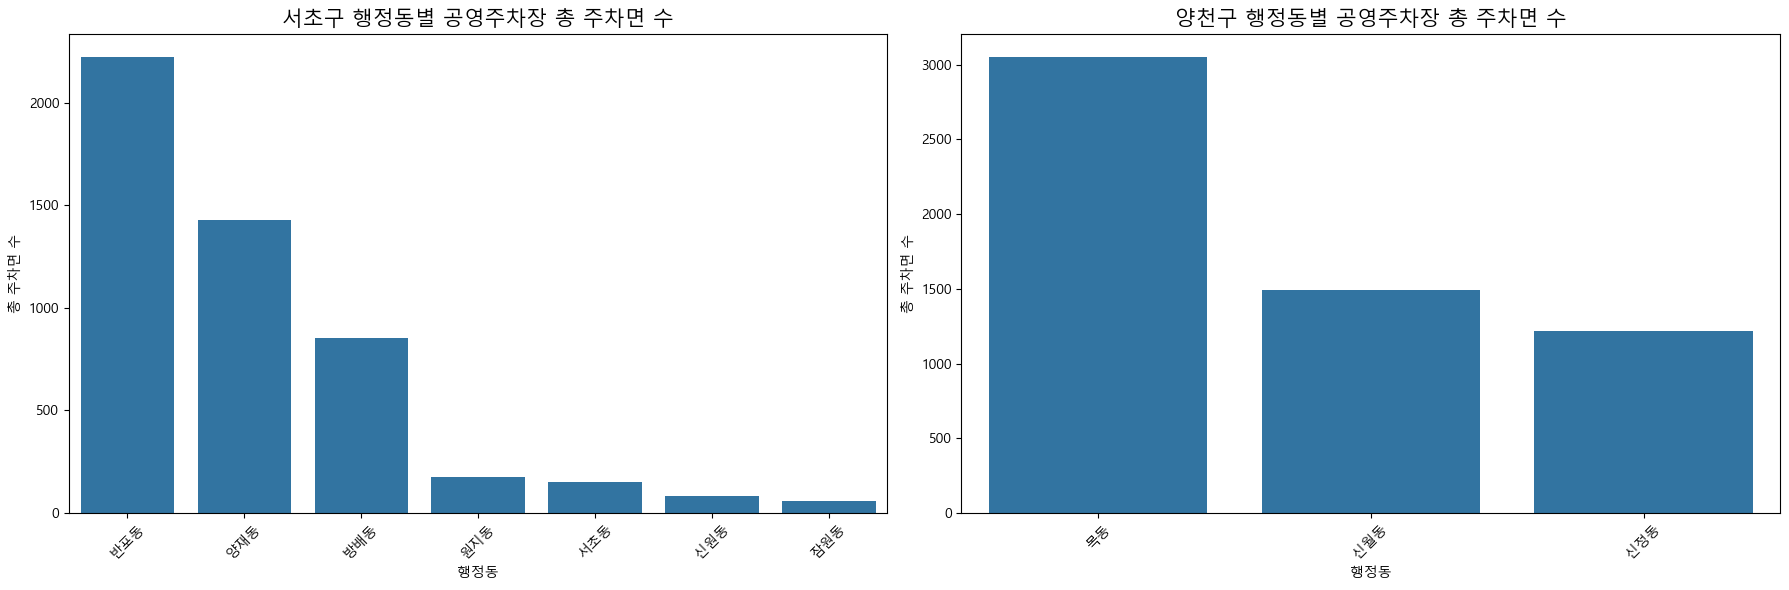

In [11]:

# 서초구 동별 주차면 수
# '주소_동'을 기준으로 그룹화하여 '총 주차면'의 합계를 계산하고, 내림차순으로 정렬합니다.
sc_parking_supply = seocho_parking_lot.groupby('주소_동')['총 주차면'].sum().sort_values(ascending=False)

# 양천구 동별 주차면 수
# '주소_동'을 기준으로 그룹화하여 '총 주차면'의 합계를 계산하고, 내림차순으로 정렬합니다.
yc_parking_supply = yangcheon_parking_lot.groupby('주소_동')['총 주차면'].sum().sort_values(ascending=False)

# 1행 2열의 서브플롯 생
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 서초구 주차장 공급 현황
# 동별 총 주차면 수를 막대그래프로 시각화합니다.
sns.barplot(sc_parking_supply, ax=axes[0])
axes[0].set_title('서초구 행정동별 공영주차장 총 주차면 수', fontsize=15)
axes[0].set_xlabel('행정동')
axes[0].set_ylabel('총 주차면 수')
axes[0].tick_params(axis='x', rotation=45)

# 양천구 주차장 공급 현황
# 동별 총 주차면 수를 막대그래프로 시각화합니다.
sns.barplot(yc_parking_supply, ax=axes[1])
axes[1].set_title('양천구 행정동별 공영주차장 총 주차면 수', fontsize=15)
axes[1].set_xlabel('행정동')
axes[1].set_ylabel('총 주차면 수')
axes[1].tick_params(axis='x', rotation=45)

# 레이아웃을 조정하고 그래프를 출력합니다.
plt.tight_layout()
plt.show()

## 2.3. 주차장 공급과 불법 주정차의 연관 분석
주차 공간이 부족한 곳에서 불법 주정차가 많이 발생하는지 확인하기 위해, 동별 단속 건수와 총 주차면 수를 이중 축 그래프로 시각화하여 비교 분석합니다.

### **주차장 공급과 불법 주정차 위반과의 관계 살펴보기**

주차장 공급과 불법 주정차 단속 건수와의 관계를 확인해 봅니다.

**처리절차 예시**
  - 데이터 프레임으로 변환 : 분석을 위해 Series 형태의 데이터를 DataFrame으로 변환합니다.
  - 데이터 병합 : '주소_동'을 기준으로 단속 건수 데이터와 주차면 수 데이터를 병합합니다.
  - 시각화 : 단속건수를 막대그래프로 그립니다. 총주차면을 꺾은선그래프로 그립니다.


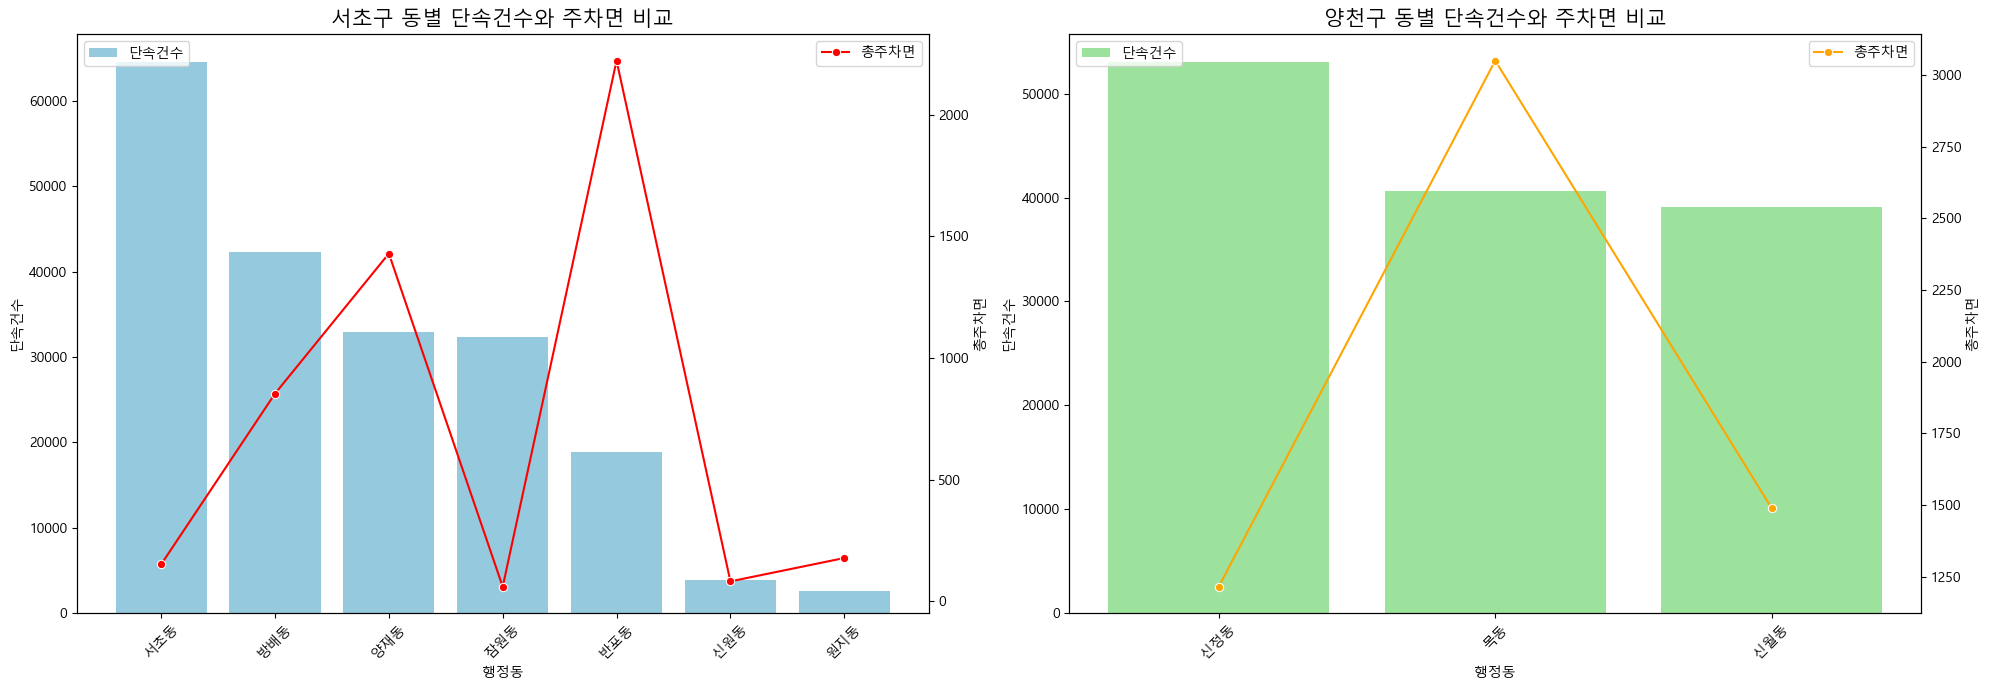

In [12]:
# 4. 연관 분석: 주차장 공급과 불법 주정차의 관계
# 데이터 프레임으로 변환
# 분석을 위해 Series 형태의 데이터를 DataFrame으로 변환합니다.
seocho_crackdown_counts = seocho_top_dong.reset_index()
seocho_crackdown_counts.columns = ['주소_동', '단속건수']
seocho_parking_supply_df = sc_parking_supply.reset_index()
seocho_parking_supply_df.columns = ['주소_동', '총주차면']

# 데이터 병합
# '주소_동'을 기준으로 단속 건수 데이터와 주차면 수 데이터를 병합합니다. (how='inner'는 양쪽에 모두 존재하는 동만 선택)
seocho_merged = pd.merge(seocho_crackdown_counts, seocho_parking_supply_df, on='주소_동', how='inner')

# 양천구 데이터도 동일하게 처리
yangcheon_crackdown_counts = yangcheon_top_dong.reset_index()
yangcheon_crackdown_counts.columns = ['주소_동', '단속건수']
yangcheon_parking_supply_df = yc_parking_supply.reset_index()
yangcheon_parking_supply_df.columns = ['주소_동', '총주차면']
yangcheon_merged = pd.merge(yangcheon_crackdown_counts, yangcheon_parking_supply_df, on='주소_동', how='inner')

# --- 시각화 ---
# 1행 2열의 서브플롯을 생성합니다.
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# 서초구
# 기본 축(ax1)과 보조 y축(ax2)을 생성합니다. twinx()는 x축을 공유하는 보조 축을 만듭니다.
ax1 = axes[0]
ax2 = ax1.twinx()
# ax1에는 단속건수를 막대그래프로 그립니다.
sns.barplot(x='주소_동', y='단속건수', data=seocho_merged, ax=ax1, color='skyblue', label='단속건수')
# ax2에는 총주차면을 꺾은선그래프로 그립니다.
sns.lineplot(x='주소_동', y='총주차면', data=seocho_merged, ax=ax2, color='red', marker='o', label='총주차면')
ax1.set_title('서초구 동별 단속건수와 주차면 비교', fontsize=15)
ax1.set_xlabel('행정동')
ax1.set_ylabel('단속건수')
ax2.set_ylabel('총주차면')
ax1.tick_params(axis='x', rotation=45)
# 각 축의 범례(legend) 위치를 지정합니다.
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 양천구
# 서초구와 동일한 방식으로 보조 축을 활용한 그래프를 그립니다.
ax3 = axes[1]
ax4 = ax3.twinx()
sns.barplot(x='주소_동', y='단속건수', data=yangcheon_merged, ax=ax3, color='lightgreen', label='단속건수')
sns.lineplot(x='주소_동', y='총주차면', data=yangcheon_merged, ax=ax4, color='orange', marker='o', label='총주차면')
ax3.set_title('양천구 동별 단속건수와 주차면 비교', fontsize=15)
ax3.set_xlabel('행정동')
ax3.set_ylabel('단속건수')
ax4.set_ylabel('총주차면')
ax3.tick_params(axis='x', rotation=45)
ax3.legend(loc='upper left')
ax4.legend(loc='upper right')

# 레이아웃을 조정하고 그래프를 출력합니다.
plt.tight_layout()
plt.show()

## 3. 결론 및 아이디어 제안
### 분석 결과 요약 및 아이디어 제안
시각화된 분석 결과를 바탕으로 각 지역의 주차 문제에 대한 결론을 도출하고, 이를 해결하기 위한 구체적인 아이디어를 제시합니다.

- 서초구 잠원동: 주차면 수에 비해 단속건수가 현저히 많음. 공급 대비 수요(문제)가 가장 불균형한 지역임 (공급량을 늘릴 필요가 있음)
- 양천구 신정동: 단속 건수는 양천구 내 최상위권이지만, 주차면수는 목독의 절반 수준에 그침. 잠원동과 같은 경우로, 공급이 수요를 따라가지 못하는 지역임.
- 서초구 서초동: 주차면 수에 비해 단속건수가 현저히 많음
- 서초구 반포동: 주차면 수에 비해 단속건수가 현저히 작음. 공급 대비 수요가 가장 불균형한 지역이지만, 단속건수가 주차면수 대비 작은 지역이므로, 해당 지역에 대해 더 알아볼 필요가 있어 보임

[인사이트(예시)] 
- 단순히 불법 주정차가 많은 지역(서초동, 신정동)에만 집중하는 것은 다소 위험한 분석입니다.
- 진짜 문제는 **"보유한 주차 공간 대비 얼마나 많은 불법 주정차가 발생하는가?"** 입니다.
- 이 관점에서 볼 때, 서초구 잠원동과 양천구 신정동은 주차 인프라 부족이 가장 심각하여,
주민들이 불법 주차를 할 수밖에 없는 환경에 놓여있을 가능성이 가장 큰 지역입니다.


# **<1일차 조별과제>**


## 분석 결과와 아이디어를 검토하고, 추가적인 데이터 분석 방법을 찾아서 시각화 해 봅니다.

개별로 분석한 결과를 조/팀별 공유 및 토론을 통해서 대표적인 데이터 분석 방법 및 시각화 방법을 찾고, 구현해 봅니다. 

---

# **<2일차 개별과제>**


## 환경 설정 및 데이터 불러오기
### 라이브러리 임포트 및 한글 폰트 설정
분석에 필요한 라이브러리를 불러오고, 시각화 시 한글이 깨지지 않도록 맑은고딕 폰트를 설정합니다

In [13]:
# 데이터 분석 및 시각화를 위한 라이브러리들을 임포트합니다.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
from datetime import datetime
import os
import glob
import matplotlib.font_manager as fm
import subprocess

# 폰트 설정
plt.rc('font', family='Malgun Gothic')

# 경고 제거
import warnings
warnings.filterwarnings(action='ignore')


## 분석데이터를 추가해서, 추가적인 질문에 대한 분석을 해 봅니다.
### 2일차 추가 데이터(업체 현황정보, 생활인구)를 활용하여, 데이터 연관성을 분석해 봅니다.

### 1. 데이터 전처리 (1)

추가된 데이터에 대한 전처리(결측치, 이상치 처리)를 수행해 봅니다.
  - 사업체 현황 정보 로드 합니다.
  - 사업체 정보에서 불필요한 정보를 제거하고, 날짜정보를 전처리 합니다.

In [14]:
# 여기에 데이터 전처리 코드를 작성해보세요!

business_df = pd.read_csv('사업체현황(산업대분류별_동별).csv')
business_df.head()

,동별,산업대분류별,구분별,항목,단위,2021 년,2022 년,2023 년,Unnamed: 8
0,합계,합계,사업체수,사업체현황(산업대분류별/동별)(2017년 이후),개,1188091,1180025,1177287,NaN
1,합계,합계,여성대표자,사업체현황(산업대분류별/동별)(2017년 이후),NaN,407948,405170,410925,NaN
2,합계,합계,종사자수,사업체현황(산업대분류별/동별)(2017년 이후),명,5771226,5795425,5800617,NaN
3,합계,합계,남,사업체현황(산업대분류별/동별)(2017년 이후),NaN,3218529,3208120,3175955,NaN
4,합계,합계,여,사업체현황(산업대분류별/동별)(2017년 이후),NaN,2552697,2587305,2624662,NaN


In [17]:
business_dong_df = business_df[
    (business_df['동별'] != '합계') &
    (business_df['산업대분류별'] != '합계')  # 필요한 만큼 추가 가능
]
business_dong_df = business_dong_df.dropna(axis=1)
business_dong_df

,동별,산업대분류별,구분별,항목,단위
48,종로구,농업 임업 및 어업,사업체수,사업체현황(산업대분류별/동별)(2017년 이후),개
49,종로구,농업 임업 및 어업,종사자수,사업체현황(산업대분류별/동별)(2017년 이후),명
50,종로구,광업,사업체수,사업체현황(산업대분류별/동별)(2017년 이후),개
51,종로구,광업,종사자수,사업체현황(산업대분류별/동별)(2017년 이후),명
52,종로구,제조업,사업체수,사업체현황(산업대분류별/동별)(2017년 이후),개
...,...,...,...,...,...
19474,상일2동,보건업 및 사회복지 서비스업,종사자수,사업체현황(산업대분류별/동별)(2017년 이후),명
19475,상일2동,예술 스포츠 및 여가관련 서비스업,사업체수,사업체현황(산업대분류별/동별)(2017년 이후),개
19476,상일2동,예술 스포츠 및 여가관련 서비스업,종사자수,사업체현황(산업대분류별/동별)(2017년 이후),명
19477,상일2동,협회 및 단체 수리 및 기타 개인 서비스업,사업체수,사업체현황(산업대분류별/동별)(2017년 이후),개


In [18]:
business_total_df = business_df[
    (business_df['동별'] == '합계') &
    (business_df['산업대분류별'] == '합계')  # 필요한 만큼 추가 가능
]
business_total_df = business_total_df.dropna(axis=1)
business_total_df

,동별,산업대분류별,구분별,항목,2021 년,2022 년,2023 년
0,합계,합계,사업체수,사업체현황(산업대분류별/동별)(2017년 이후),1188091,1180025,1177287
1,합계,합계,여성대표자,사업체현황(산업대분류별/동별)(2017년 이후),407948,405170,410925
2,합계,합계,종사자수,사업체현황(산업대분류별/동별)(2017년 이후),5771226,5795425,5800617
3,합계,합계,남,사업체현황(산업대분류별/동별)(2017년 이후),3218529,3208120,3175955
4,합계,합계,여,사업체현황(산업대분류별/동별)(2017년 이후),2552697,2587305,2624662


### 1. 데이터 전처리 (2)
  - 행정동코드 데이터를 로드 합니다.
  - 행정동코드 데이터에서 불필요한 데이터를 제거 합니다.

In [19]:
# 여기에 데이터 전처리 코드를 작성해보세요!

local_code_df = pd.read_excel('행정동코드_매핑정보_20241218.xlsx')
local_code_df = local_code_df[1:].reset_index(drop=True)
local_code_df

,통계청행정동코드,행자부행정동코드,시도명,시군구명,행정동명
0,1101053,11110530,서울,종로구,사직동
1,1101054,11110540,서울,종로구,삼청동
2,1101055,11110550,서울,종로구,부암동
3,1101056,11110560,서울,종로구,평창동
4,1101057,11110570,서울,종로구,무악동
...,...,...,...,...,...
419,1125070,11740690,서울,강동구,둔촌1동
420,1125071,11740700,서울,강동구,둔촌2동
421,1125072,11740570,서울,강동구,암사1동
422,1125073,11740610,서울,강동구,천호2동


In [ ]:
# 여기에 데이터 전처리 코드를 작성해보세요!





### 1. 데이터 전처리 (3)
  - 서울 생활인구(내국인)을 로드 한다.
  - 행정동코드 데이터와 머징하여 지역정보를 추가 합니다.

In [20]:
# 여기에 데이터 전처리 코드를 작성해보세요!

seoul_p_df = pd.read_csv('집계구 단위 서울 생활인구(내국인).csv', encoding='cp949')
seoul_p_df

,기준일ID,시간대구분,행정동코드,집계구코드,총생활인구수,남자0세부터9세생활인구수,남자10세부터14세생활인구수,남자15세부터19세생활인구수,남자20세부터24세생활인구수,남자25세부터29세생활인구수,...,여자25세부터29세생활인구수,여자30세부터34세생활인구수,여자35세부터39세생활인구수,여자40세부터44세생활인구수,여자45세부터49세생활인구수,여자50세부터54세생활인구수,여자55세부터59세생활인구수,여자60세부터64세생활인구수,여자65세부터69세생활인구수,여자70세이상생활인구수
0,20250903,23,11110515,1101072010017,1835.1288,87.7776,55.9321,40.7301,28.1886,38.2896,...,59.4021,59.9453,83.8427,104.8406,93.461,93.5254,78.6499,57.6855,41.4919,130.9834
1,20250903,23,11110515,1101072020002,862.2569,30.1655,19.2215,25.7567,15.594,23.402,...,16.8398,21.4108,37.8701,43.5672,33.9987,36.0166,22.6311,32.5866,12.0757,31.1103
2,20250903,23,11110515,1101072020001,363.6847,10.3782,6.613,11.2598,8.4931,11.2367,...,13.7746,15.4571,11.8048,18.5993,15.0934,17.7104,14.0016,12.4458,6.7584,37.9498
3,20250903,23,11110515,1101072010101,199.5235,12.3491,7.8688,9.3699,4.3232,4.1106,...,4.652,5.2277,7.3868,7.6566,10.8043,7.6146,7.195,9.9763,*,7.0931
4,20250903,23,11110515,1101072010020,69.0185,*,*,*,*,*,...,*,*,*,*,*,4.5223,*,*,*,5.7698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458714,20250903,0,11740700,1125071022201,827.7040,35.3535,17.8342,26.4212,16.9995,18.1067,...,39.3273,30.406,40.6911,30.0621,48.1427,33.9393,38.5246,30.1778,21.625,80.4699
458715,20250903,0,11740700,1125071022202,201.4445,7.1638,*,7.2417,4.2136,4.1654,...,10.0107,7.5904,11.0927,7.2803,12.1045,8.6239,9.3838,7.3755,5.2091,20.5177
458716,20250903,0,11740700,1125071022501,896.5508,46.4948,23.4545,26.8573,10.418,9.9311,...,22.9314,53.8144,43.6948,49.517,45.9143,32.1249,34.2018,31.0158,22.9324,72.12
458717,20250903,0,11740700,1125071022701,18.6741,*,*,*,*,*,...,*,*,*,*,*,*,*,*,*,*


In [22]:
# 여기에 데이터 전처리 코드를 작성해보세요!
# 데이터 타입 맞추기
local_code_df['행자부행정동코드'] = local_code_df['행자부행정동코드'].astype(str)
seoul_p_df['행정동코드'] = seoul_p_df['행정동코드'].astype(str)

# 기준 열로 병합
seoul_p_merge = pd.merge(
    local_code_df,
    seoul_p_df,
    left_on='행자부행정동코드',
    right_on='행정동코드',
    how='outer'  # 또는 'left'
)
seoul_p_merge

,통계청행정동코드,행자부행정동코드,시도명,시군구명,행정동명,기준일ID,시간대구분,행정동코드,집계구코드,총생활인구수,...,여자25세부터29세생활인구수,여자30세부터34세생활인구수,여자35세부터39세생활인구수,여자40세부터44세생활인구수,여자45세부터49세생활인구수,여자50세부터54세생활인구수,여자55세부터59세생활인구수,여자60세부터64세생활인구수,여자65세부터69세생활인구수,여자70세이상생활인구수
0,1101072,11110515,서울,종로구,청운효자동,20250903,23,11110515,1101072010017,1835.1288,...,59.4021,59.9453,83.8427,104.8406,93.461,93.5254,78.6499,57.6855,41.4919,130.9834
1,1101072,11110515,서울,종로구,청운효자동,20250903,23,11110515,1101072020002,862.2569,...,16.8398,21.4108,37.8701,43.5672,33.9987,36.0166,22.6311,32.5866,12.0757,31.1103
2,1101072,11110515,서울,종로구,청운효자동,20250903,23,11110515,1101072020001,363.6847,...,13.7746,15.4571,11.8048,18.5993,15.0934,17.7104,14.0016,12.4458,6.7584,37.9498
3,1101072,11110515,서울,종로구,청운효자동,20250903,23,11110515,1101072010101,199.5235,...,4.652,5.2277,7.3868,7.6566,10.8043,7.6146,7.195,9.9763,*,7.0931
4,1101072,11110515,서울,종로구,청운효자동,20250903,23,11110515,1101072010020,69.0185,...,*,*,*,*,*,4.5223,*,*,*,5.7698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458714,1125071,11740700,서울,강동구,둔촌2동,20250903,0,11740700,1125071022201,827.7040,...,39.3273,30.406,40.6911,30.0621,48.1427,33.9393,38.5246,30.1778,21.625,80.4699
458715,1125071,11740700,서울,강동구,둔촌2동,20250903,0,11740700,1125071022202,201.4445,...,10.0107,7.5904,11.0927,7.2803,12.1045,8.6239,9.3838,7.3755,5.2091,20.5177
458716,1125071,11740700,서울,강동구,둔촌2동,20250903,0,11740700,1125071022501,896.5508,...,22.9314,53.8144,43.6948,49.517,45.9143,32.1249,34.2018,31.0158,22.9324,72.12
458717,1125071,11740700,서울,강동구,둔촌2동,20250903,0,11740700,1125071022701,18.6741,...,*,*,*,*,*,*,*,*,*,*


### 2. 데이터 분석 및 시각화 (1)

추가된 데이터에 대한 탐색적 데이터 분석을 수행해 봅니다. 1일차의 제안 아이디어에 대한 개선점이 될 수 있는지 확인해 봅니다.

  - 신정동과 잠원동의 주차면수 부족 원인 파악을 위해, 신정동과 잠원동 소재의 사업체 현황을 확인해 봅니다.

In [28]:
# 신정동의 산업체 현황 파악

# 1. 신정동만 필터링
target_dong_df = business_dong_df[business_dong_df['동별'].isin(['신정동'])]

# 2. 산업대분류별로 그룹화해서 사업체 수 집계
grouped = target_dong_df.groupby(['동별', '산업대분류별']).size().reset_index(name='사업체수')
grouped


,동별,산업대분류별,사업체수


In [25]:
# 신정동과 잠원동의 산업체 현황 파악

# 1. 신정동과 잠원동만 필터링
target_dong_df = business_dong_df[business_dong_df['동별'].isin(['신정동', '잠원동'])]

# 2. 산업대분류별로 그룹화해서 사업체 수 집계
grouped = target_dong_df.groupby(['동별', '산업대분류별']).size().reset_index(name='사업체수')
grouped


,동별,산업대분류별,사업체수
0,잠원동,건설업,2
1,잠원동,공공행정 국방 및 사회보장 행정,2
2,잠원동,광업,2
3,잠원동,교육 서비스업,2
4,잠원동,금융 및 보험업,2
5,잠원동,농업 임업 및 어업,2
6,잠원동,도매 및 소매업,2
7,잠원동,보건업 및 사회복지 서비스업,2
8,잠원동,부동산업,2
9,잠원동,사업시설 관리 사업 지원 및 임대 서비스업,2


In [32]:
# 잠원동의 산업체 현황 파악




### 2. 데이터 분석 및 시각화 (2)

  - 두 지역에서의 시간대 및 연령대별 생활반응 분석을 통해 연관 관계를 도출합니다.

In [33]:
# 여기에 데이터 분석 및 시각화 코드를 작성해보세요!





In [34]:
# 여기에 데이터 분석 및 시각화 코드를 작성해보세요!





### 3. 인사이트 도출

데이터 분석 근거에 대한 결론을 도출하고 제안에 맞는지 확인 해 봅니다.
제안 근거 및 설득력 있는 시각화를 위해서 어떤 방식이 좋은지 생각해 봅니다.


여기에 의견을 적어 봅니다.




# **<2일차 조별과제>**

## 분석 결과와 아이디어를 검토하고, 추가적인 데이터 분석 방법을 찾아서 시각화 해 봅니다.

개별로 분석한 결과를 조/팀별 공유 및 토론을 통해서 대표적인 데이터 분석 방법 및 시각화 방법을 찾고, 구현해 봅니다. 

In [35]:
# 여기에 코드를 작성해보세요!





In [36]:
# 여기에 데이터 분석 및 시각화 코드를 작성해보세요!





### 3. 최종 제안 아이디어 정리

프로젝트 목적에 맞는 결론을 정리하여, 발표자료에 사용할 내용을 정리해 봅니다.


여기에 의견을 적어 봅니다.

